In [1]:
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

#@title Seleccione Acción y Fecha {run:'auto'}
ticker = "AMD" #@param ["AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META", "TSM","BRK.B", "V", "JPM", "XOM", "LLY", "MRK", "UNH", "PG", "MA","CVX", "KO", "PEP", "COST", "TMO", "ORCL", "CSCO", "NKE", "VZ", "ASML", "TXN", "ABT", "TM", "SAP", "AMD", "NFLX", "NOW", "ADBE", "LVMUY", "BABA", "SHEL", "TMUS", "QCOM", "PFE", "SNY", "AZN", "TOT", "GSK", "RIO", "BHP", "MCD​"]
# ticker = "DOGE-USD" #@param ["DOGE-USD","BTC-USD", "ETH-USD", "USDT-USD", "XRP-USD", "LTC-USD", "ADA-USD", "DOT-USD", "BCH-USD", "XLM-USD", "LINK-USD"]

#start_date = '2024-09-09' #@param {type:'date'}
#end_date   = '2025-09-12' #@param {type:'date'}

end_date   =  datetime.today().strftime("%Y-%m-%d")
start_date = (datetime.today() - relativedelta(years=1)).strftime("%Y-%m-%d")

Funciones

In [2]:
# @title
# =========================
# Cálculo y gráficas de indicadores
# =========================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ---------- Utilidades ----------
def rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0.0)
    loss = np.where(delta < 0, -delta, 0.0)
    gain_ema = pd.Series(gain, index=series.index).ewm(alpha=1/period, adjust=False).mean()
    loss_ema = pd.Series(loss, index=series.index).ewm(alpha=1/period, adjust=False).mean()
    rs = gain_ema / loss_ema.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def bollinger(series, window=20, num_std=2):
    ma = series.rolling(window).mean()
    std = series.rolling(window).std()
    upper = ma + num_std * std
    lower = ma - num_std * std
    return ma, upper, lower

def true_range(h, l, c_prev):
    return pd.concat([
        (h - l).abs(),
        (h - c_prev).abs(),
        (l - c_prev).abs()
    ], axis=1).max(axis=1)

def atr(high, low, close, period=14):
    c_prev = close.shift(1)
    tr = true_range(high, low, c_prev)
    return tr.ewm(alpha=1/period, adjust=False).mean()

def macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def stochastic_oscillator(high, low, close, k_period=14, d_period=3):
    lowest_low = low.rolling(k_period).min()
    highest_high = high.rolling(k_period).max()
    k = 100 * (close - lowest_low) / (highest_high - lowest_low)
    d = k.rolling(d_period).mean()
    return k, d

def cci(high, low, close, period=20):
    tp = (high + low + close) / 3
    sma_tp = tp.rolling(period).mean()
    md = (tp - sma_tp).abs().rolling(period).mean()
    return (tp - sma_tp) / (0.015 * md)

def adx(high, low, close, period=14):
    # Direccionales
    up_move   = high.diff()
    down_move = -low.diff()
    plus_dm  = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    tr = true_range(high, low, close.shift(1))
    atr_ = pd.Series(tr).ewm(alpha=1/period, adjust=False).mean()
    plus_di  = 100 * pd.Series(plus_dm, index=high.index).ewm(alpha=1/period, adjust=False).mean() / atr_
    minus_di = 100 * pd.Series(minus_dm, index=high.index).ewm(alpha=1/period, adjust=False).mean() / atr_
    dx = ( (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0, np.nan) ) * 100
    adx_ = dx.ewm(alpha=1/period, adjust=False).mean()
    return plus_di, minus_di, adx_

def obv(close, volume):
    direction = np.sign(close.diff()).fillna(0)
    return (direction * volume).cumsum()

def annualized_vol(returns, periods_per_year=252):
    return returns.std() * np.sqrt(periods_per_year)

def sharpe_ratio(returns, rf=0.0, periods_per_year=252):
    excess = returns - rf/periods_per_year
    return (excess.mean() / excess.std()) * np.sqrt(periods_per_year)

def sortino_ratio(returns, rf=0.0, periods_per_year=252):
    downside = returns.copy()
    downside[downside > 0] = 0
    dd_std = downside.std()
    if dd_std == 0:
        return np.nan
    excess = returns - rf/periods_per_year
    return (excess.mean() / dd_std) * np.sqrt(periods_per_year)

def max_drawdown(series):
    cummax = series.cummax()
    drawdown = series/cummax - 1.0
    return drawdown.min(), drawdown


Métricas del periodo y agregado de columnas con metricos al df

In [3]:
# @title
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---------- Datos ----------
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)

if data.empty:
    raise SystemExit(f"No hay datos para {ticker} entre {start_date} y {end_date}")

# Normalizar si viene en MultiIndex (a veces en cripto/FX)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# ---------- Indicadores ----------
close = data["Close"].copy()
high  = data["High"].copy()
low   = data["Low"].copy()
vol   = data["Volume"].fillna(0)

# SMAs
data["SMA_10"]  = close.rolling(10).mean()
data["SMA_20"]  = close.rolling(20).mean()
data["SMA_50"]  = close.rolling(50).mean()
data["SMA_100"] = close.rolling(100).mean()
data["SMA_200"] = close.rolling(200).mean()

# EMAs
data["EMA_12"]  = close.ewm(span=12, adjust=False).mean()
data["EMA_26"]  = close.ewm(span=26, adjust=False).mean()
data["EMA_50"]  = close.ewm(span=50, adjust=False).mean()
data["EMA_100"]  = close.ewm(span=100, adjust=False).mean()
data["EMA_200"] = close.ewm(span=200, adjust=False).mean()

# RSI
data["RSI_14"] = rsi(close, 14)

# Bandas de Bollinger
bb_mid, bb_up, bb_low = bollinger(close, 20, 2)
data["BB_Mid_20"]  = bb_mid
data["BB_Upper_20_2"] = bb_up
data["BB_Lower_20_2"] = bb_low

# ATR
data["ATR_14"] = atr(high, low, close, 14)

# MACD
macd_line, signal_line, macd_hist = macd(close, 12, 26, 9)
data["MACD"]   = macd_line
data["Signal"] = signal_line
data["MACD_Hist"] = macd_hist

# Estocástico
k, d = stochastic_oscillator(high, low, close, 14, 3)
data["Stoch_%K_14"] = k
data["Stoch_%D_3"]  = d

# CCI
data["CCI_20"] = cci(high, low, close, 20)

# ADX
plus_di, minus_di, adx_val = adx(high, low, close, 14)
data["+DI_14"] = plus_di
data["-DI_14"] = minus_di
data["ADX_14"] = adx_val

# OBV
data["OBV"] = obv(close, vol)

# Rendimientos
data["ret_d"]   = close.pct_change()
data["ret_cum"] = (1 + data["ret_d"]).cumprod()

# ---------- Métricas del periodo ----------
ann_vol   = annualized_vol(data["ret_d"].dropna())
sharpe    = sharpe_ratio(data["ret_d"].dropna(), rf=0.0)
sortino   = sortino_ratio(data["ret_d"].dropna(), rf=0.0)
mdd, dd_series = max_drawdown(data["ret_cum"].dropna())

metrics = {
    "Ticker": ticker,
    "Inicio": str(data.index.min().date()),
    "Fin":    str(data.index.max().date()),
    "Vol anualizada": float(ann_vol) if pd.notna(ann_vol) else np.nan,
    "Sharpe (rf=0)": float(sharpe) if pd.notna(sharpe) else np.nan,
    "Sortino (rf=0)": float(sortino) if pd.notna(sortino) else np.nan,
    "Max Drawdown en un dia": float(mdd) if pd.notna(mdd) else np.nan
}
print("=== Métricas del periodo ===")
for k,v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")


=== Métricas del periodo ===
Ticker: AMD
Inicio: 2024-09-16
Fin: 2025-09-12
Vol anualizada: 0.5210
Sharpe (rf=0): 0.3354
Sortino (rf=0): 0.6002
Max Drawdown en un dia: -0.5474


Gráfico SMA vs EMA

In [4]:
# @title
# ========= Gráfico SMA vs EMA =========
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.05,
                    row_heights=[0.5, 0.5],
                    subplot_titles=(f"{ticker} con SMA (10,20,50)", f"{ticker} con EMA (10,20,50)"))

# --- SMAs ---
fig.add_trace(go.Scatter(x=data.index, y=data["Close"],
                         name="Close", line=dict(color="green")), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["Close"].rolling(10).mean(),
                         name="SMA10", line=dict(color="orange")), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["Close"].rolling(20).mean(),
                         name="SMA20", line=dict(color="blue")), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["Close"].rolling(100).mean(),
                         name="SMA100", line=dict(color="purple")), row=1, col=1)

# --- EMAs ---
fig.add_trace(go.Scatter(x=data.index, y=data["Close"],
                         name="Close", line=dict(color="green")), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["Close"].ewm(span=10, adjust=False).mean(),
                         name="EMA10", line=dict(color="orange")), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["Close"].ewm(span=20, adjust=False).mean(),
                         name="EMA20", line=dict(color="blue")), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["Close"].ewm(span=100, adjust=False).mean(),
                         name="EMA100", line=dict(color="purple")), row=2, col=1)

# Ejes y estilo
fig.update_yaxes(title_text="Precio", row=1, col=1)
fig.update_yaxes(title_text="Precio", row=2, col=1)
fig.update_layout(title=f"Comparación SMA vs EMA — {ticker}",
                  xaxis_rangeslider_visible=False,
                  template="plotly_white", height=900)

fig.show()

In [5]:
# @title
# ========= OHLC + Bollinger =========
fig_ohlc = go.Figure()

# OHLC
fig_ohlc.add_trace(go.Ohlc(x=data.index,
                           open=data["Open"],
                           high=data["High"],
                           low=data["Low"],
                           close=data["Close"],
                           name="OHLC"))

# Bandas de Bollinger (sombra)
fig_ohlc.add_trace(go.Scatter(x=data.index, y=bb_up, line=dict(width=0), showlegend=False))
fig_ohlc.add_trace(go.Scatter(x=data.index, y=bb_low, line=dict(width=0),
                              fill='tonexty', fillcolor='rgba(0,176,246,0.2)',
                              name="Bollinger Bands"))

# Layout
fig_ohlc.update_layout(
    title=f"{ticker} — OHLC + Bollinger",
    xaxis_title="Fecha",
    yaxis_title="Precio",
    template="plotly_white",
    xaxis_rangeslider_visible=False,
    height=600
)

fig_ohlc.show()

In [6]:
# @title
from plotly.subplots import make_subplots

# ========= Velas + RSI + MACD =========
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True,
    row_heights=[0.5, 0.25, 0.25],
    vertical_spacing=0.04,
    subplot_titles=(f"{ticker} — Velas Japonesas", "RSI(14)", "MACD (12,26,9)")
)

# --- Velas Japonesas ---
fig.add_trace(go.Candlestick(
    x=data.index,
    open=data["Open"],
    high=data["High"],
    low=data["Low"],
    close=data["Close"],
    name="Candlestick"
), row=1, col=1)

# EMA20 y EMA100
data["EMA20"] = data["Close"].ewm(span=20, adjust=False).mean()
data["EMA100"] = data["Close"].ewm(span=100, adjust=False).mean()

fig.add_trace(go.Scatter(
    x=data.index, y=data["EMA20"],
    mode="lines", name="EMA20",
    line=dict(color="purple")
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=data.index, y=data["EMA100"],
    mode="lines", name="EMA100",
    line=dict(color="blue")
), row=1, col=1)

# --- RSI ---
fig.add_trace(go.Scatter(
    x=data.index, y=data["RSI_14"],
    mode="lines", name="RSI(14)", line=dict(color="blue")
), row=2, col=1)

# Zonas sobrecompra/venta
fig.add_shape(type="rect",
              x0=data.index.min(), x1=data.index.max(),
              y0=70, y1=100, fillcolor="rgba(0,255,0,0.15)", line=dict(width=0),
              row=2, col=1)
fig.add_shape(type="rect",
              x0=data.index.min(), x1=data.index.max(),
              y0=0, y1=30, fillcolor="rgba(255,0,0,0.15)", line=dict(width=0),
              row=2, col=1)

# Líneas guía RSI
fig.add_shape(type="line", x0=data.index.min(), x1=data.index.max(),
              y0=70, y1=70, line=dict(color="green", dash="dash"),
              row=2, col=1)
fig.add_shape(type="line", x0=data.index.min(), x1=data.index.max(),
              y0=30, y1=30, line=dict(color="red", dash="dash"),
              row=2, col=1)

# --- MACD ---
fig.add_trace(go.Scatter(
    x=data.index, y=data["MACD"],
    mode="lines", name="MACD", line=dict(color="blue")
), row=3, col=1)

fig.add_trace(go.Scatter(
    x=data.index, y=data["Signal"],
    mode="lines", name="Signal", line=dict(color="orange")
), row=3, col=1)

fig.add_trace(go.Bar(
    x=data.index, y=data["MACD_Hist"],
    name="Hist", marker_color="purple", opacity=0.4
), row=3, col=1)

# --- Layout ---
fig.update_yaxes(title_text="Precio", row=1, col=1)
fig.update_yaxes(title_text="RSI", row=2, col=1, range=[0,100])
fig.update_yaxes(title_text="MACD", row=3, col=1)

fig.update_layout(
    title=f"Análisis Técnico — {ticker} (Velas, RSI y MACD)",
    template="plotly_white",
    xaxis_rangeslider_visible=False,
    height=1000,
    legend_tracegroupgap=10
)

fig.show()

In [7]:
# @title
from plotly.subplots import make_subplots

# ========= Velas Japonesas + ATR =========
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.05,
    subplot_titles=(f"{ticker} — Velas Japonesas", "ATR(14) - Average True Range")
)

# --- Velas Japonesas ---
fig.add_trace(go.Candlestick(
    x=data.index,
    open=data["Open"],
    high=data["High"],
    low=data["Low"],
    close=data["Close"],
    name="Candlestick"
), row=1, col=1)

# --- ATR(14) ---
fig.add_trace(go.Scatter(
    x=data.index, y=data["ATR_14"],
    mode="lines", name="ATR(14)",
    line=dict(color="red")
), row=2, col=1)

# --- Layout ---
fig.update_yaxes(title_text="Precio", row=1, col=1)
fig.update_yaxes(title_text="ATR", row=2, col=1)

fig.update_layout(
    title=f"Análisis Técnico — {ticker} (Velas y ATR)",
    template="plotly_white",
    xaxis_rangeslider_visible=False,
    height=800,
    legend_tracegroupgap=8
)

fig.show()

In [8]:
# @title
from plotly.subplots import make_subplots

# ========= Velas Japonesas + Estocástico =========
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.05,
    subplot_titles=(f"{ticker} — Velas Japonesas", "Oscilador Estocástico (14,3)")
)

# --- Velas Japonesas ---
fig.add_trace(go.Candlestick(
    x=data.index,
    open=data["Open"],
    high=data["High"],
    low=data["Low"],
    close=data["Close"],
    name="Candlestick"
), row=1, col=1)

# --- Estocástico %K y %D ---
fig.add_trace(go.Scatter(
    x=data.index, y=data["Stoch_%K_14"],
    mode="lines", name="%K(14)", line=dict(color="blue")
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=data.index, y=data["Stoch_%D_3"],
    mode="lines", name="%D(3)", line=dict(color="orange")
), row=2, col=1)

# Líneas guía 80 / 20
fig.add_shape(type="line", x0=data.index.min(), x1=data.index.max(),
              y0=80, y1=80, line=dict(color="green", dash="dash"),
              row=2, col=1)
fig.add_shape(type="line", x0=data.index.min(), x1=data.index.max(),
              y0=20, y1=20, line=dict(color="red", dash="dash"),
              row=2, col=1)

# --- Layout ---
fig.update_yaxes(title_text="Precio", row=1, col=1)
fig.update_yaxes(title_text="Oscilador (%)", row=2, col=1, range=[0,100])

fig.update_layout(
    title=f"Análisis Técnico — {ticker} (Velas y Oscilador Estocástico)",
    template="plotly_white",
    xaxis_rangeslider_visible=False,
    height=800,
    legend_tracegroupgap=8
)

fig.show()

In [9]:
# @title
from plotly.subplots import make_subplots

# ========= Velas Japonesas + ADX y DI =========
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.05,
    subplot_titles=(f"{ticker} — Velas Japonesas", "ADX(14) y DI")
)

# --- Velas Japonesas ---
fig.add_trace(go.Candlestick(
    x=data.index,
    open=data["Open"],
    high=data["High"],
    low=data["Low"],
    close=data["Close"],
    name="Candlestick"
), row=1, col=1)

# --- ADX y DI ---
fig.add_trace(go.Scatter(
    x=data.index, y=data["+DI_14"],
    mode="lines", name="+DI(14)", line=dict(color="green")
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=data.index, y=data["-DI_14"],
    mode="lines", name="-DI(14)", line=dict(color="red")
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=data.index, y=data["ADX_14"],
    mode="lines", name="ADX(14)", line=dict(color="blue", dash="dash")
), row=2, col=1)

# Línea guía en 25%
fig.add_shape(type="line",
              x0=data.index.min(), x1=data.index.max(),
              y0=25, y1=25,
              line=dict(color="gray", dash="dash"),
              row=2, col=1)
# Línea guía en 40%
fig.add_shape(type="line",
              x0=data.index.min(), x1=data.index.max(),
              y0=40, y1=40,
              line=dict(color="gray", dash="dash"),
              row=2, col=1)

# --- Layout ---
fig.update_yaxes(title_text="Precio", row=1, col=1)
fig.update_yaxes(title_text="Índice", row=2, col=1)

fig.update_layout(
    title=f"Análisis Técnico — {ticker} (Velas y ADX/DI) - ADX (Average Directional Index) y Direccionales (+DI, −DI))",
    template="plotly_white",
    xaxis_rangeslider_visible=False,
    height=800,
    legend_tracegroupgap=8
)

fig.show()



📊 Lo que ves en el gráfico

	•	Línea verde (+DI 14): mide la fuerza alcista.
	•	Línea roja (−DI 14): mide la fuerza bajista.
	•	Línea azul discontinua (ADX 14): mide la fuerza de la tendencia, sin importar si es alcista o bajista.
	•	Línea negra punteada en 25: umbral típico → por encima de 25 se considera tendencia fuerte.

⸻

🔍 Interpretación por periodos

	1.	Sep – Nov 2024:
	•	ADX muy alto al inicio (>70) pero cayendo.
	•	+DI (verde) subió con fuerza, lo que indica que la tendencia alcista dominaba.
	•	Luego empezó a converger con −DI, mostrando pérdida de impulso.
	2.	Dic 2024 – Mar 2025:
	•	ADX en niveles medios (25–40).
	•	Varios cruces entre +DI (verde) y −DI (rojo).
	•	Esto refleja un mercado con pequeñas tendencias alternadas (subidas y bajadas cortas).
	3.	Abr – Jul 2025:
	•	ADX se mantiene cerca del umbral 25 → no hay tendencia clara.
	•	+DI y −DI muy cercanos → mercado en consolidación lateral.
	4.	Ago – Sep 2025:
	•	ADX cae por debajo de 25.
	•	Las líneas verde y roja siguen alternándose → confirma ausencia de una tendencia fuerte.

⸻

📌 Conclusión

	•	Hubo un gran rally inicial (alcista) en octubre 2024, confirmado por +DI alto y ADX fuerte.
	•	Después, el mercado entró en oscilaciones menores, sin tendencia prolongada.
	•	Actualmente (sep 2025), el ADX está bajo (<25) → el activo está en rango lateral, sin una dirección definida.

👉 En términos de trading:

	•	Las mejores oportunidades fueron cuando ADX > 25 y +DI estaba sobre −DI (alcista) o al revés (bajista).
	•	Hoy, con ADX bajo, el mercado está en consolidación → no hay tendencia clara.



In [10]:
# @title
from plotly.subplots import make_subplots

# ========= Velas Japonesas + OBV =========
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.05,
    subplot_titles=(f"{ticker} — Velas Japonesas", "OBV (On Balance Volume)")
)

# --- Velas Japonesas ---
fig.add_trace(go.Candlestick(
    x=data.index,
    open=data["Open"],
    high=data["High"],
    low=data["Low"],
    close=data["Close"],
    name="Candlestick"
), row=1, col=1)

# --- OBV ---
fig.add_trace(go.Scatter(
    x=data.index, y=data["OBV"],
    mode="lines", name="OBV",
    line=dict(color="purple")
), row=2, col=1)

# --- Layout ---
fig.update_yaxes(title_text="Precio", row=1, col=1)
fig.update_yaxes(title_text="Volumen Acumulado", row=2, col=1)

fig.update_layout(
    title=f"Análisis Técnico — {ticker} (Velas y OBV)",
    template="plotly_white",
    xaxis_rangeslider_visible=False,
    height=800,
    legend_tracegroupgap=8
)

fig.show()

Gráfico es el OBV (On Balance Volume), que mide la presión de compra y venta acumulando volumen según si el precio cierra al alza o a la baja.

⸻

📊 ¿Qué nos muestra el gráfico?

1.	Inicio plano (antes de oct-2024):
El OBV estaba casi en 0, lo que indica que el volumen era bajo o no había una dirección clara (ni compradores ni vendedores dominaban).

2.	Gran subida (oct-2024):
Se ve un salto muy fuerte del OBV hasta más de 150B.

👉 Esto significa que en esos días hubo mucho volumen acompañando subidas de precio, es decir, una fuerte acumulación.
Probablemente el precio también tuvo un rally fuerte en ese periodo.

3.	Meses posteriores (nov-2024 a mar-2025):
El OBV se mantiene alto pero empieza a descender ligeramente, aunque todavía sigue en niveles elevados.

👉 Señal de que hubo cierta distribución (ventas con volumen) tras el rally inicial, pero no se perdió todo el impulso.

4.	Consolidación (mar-2025 a sep-2025):
El OBV se mueve de manera lateral, en un rango estable.

👉 Indica que el volumen ya no empuja fuerte ni hacia la compra ni hacia la venta → el mercado está en una fase de equilibrio o consolidación.

⸻

📌 Interpretación práctica

	•	El fuerte pico en octubre 2024 confirma que los compradores entraron con gran fuerza (probablemente disparando el precio).
	•	El descenso progresivo muestra que luego se fue perdiendo interés comprador y algunos vendieron parte de sus posiciones.
	•	La lateralidad actual en OBV indica que el activo está estable, y cualquier ruptura (arriba o abajo) acompañada por un nuevo movimiento en OBV podría anticipar la próxima gran tendencia.

⸻

👉 En pocas palabras:

	•	Oct-2024: entrada masiva de volumen alcista.
	•	Nov 2024 – Mar 2025: ligera distribución.
	•	Abr – Sep 2025: consolidación, el mercado está a la espera de una ruptura.




In [11]:
# @title
# ========= Gráfico Fibonacci con Áreas Verdes/Rojas + EMA100 =========
# EMA100
EMA = 100
data["EMA"+str(EMA)] = data["Close"].ewm(span=EMA, adjust=False).mean()

# Detectar swing (últimos 180 días)
lookback = 180
df_sw = data.tail(lookback)
max_price = df_sw["Close"].max()
min_price = df_sw["Close"].min()
lookback_date = df_sw.index.min().date()
max_price_date = df_sw.index[df_sw["Close"]==max_price][0].date()
min_price_date = df_sw.index[df_sw["Close"]==min_price][0].date()

# Ratios y niveles
ratios = [0.236, 0.382, 0.5, 0.618, 0.786]  # retrocesos estándar
levels = [max_price - (max_price - min_price) * r for r in ratios]
levels = [max_price] + levels + [min_price]  # incluir max y min

# ========= Plot =========
fig = go.Figure()

# OHLC - Open High Low close
fig.add_trace(go.Ohlc(
    x=data.index,
    open=data["Open"], high=data["High"],
    low=data["Low"], close=data["Close"],
    name="OHLC"
))

# EMA100
fig.add_trace(go.Scatter(
    x=data.index, y=data["EMA"+str(EMA)],
    mode="lines", name="EMA"+str(EMA),
    line=dict(color="purple", width=2)
))

# Áreas de Fibonacci (verde arriba, rojo abajo)
for i in range(len(levels)-1):
    lvl_top = levels[i]
    lvl_bottom = levels[i+1]

    # Determinar color según si está arriba o abajo del 50%
    if (lvl_top + lvl_bottom) / 2 >= levels[3]:  # niveles por encima del 50%
        fillcolor = "rgba(0,200,0,0.15)"  # verde alpha
    else:
        fillcolor = "rgba(200,0,0,0.15)"  # rojo alpha

    # Dibujar zona sombreada
    fig.add_trace(go.Scatter(
        x=[data.index.min(), data.index.max()],
        y=[lvl_top, lvl_top],
        mode="lines",
        line=dict(color="orange", dash="dot"),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=[data.index.min(), data.index.max()],
        y=[lvl_bottom, lvl_bottom],
        mode="lines",
        line=dict(color="orange", dash="dot"),
        fill='tonexty',
        fillcolor=fillcolor,
        showlegend=False
    ))

ratios.sort(reverse=True)
# Anotaciones
for i, lvl in enumerate(levels[1:-1], start=1):
    fig.add_annotation(x=data.index[-1], y=lvl,
                       text=f"{ratios[i-1]*100:.1f}%, (${lvl:,.2f})",
                       showarrow=False, xanchor="left",
                       font=dict(size=10, color="orange"))

fig.add_annotation(x=data.index[-1], y=max_price, text=f"Max (${max_price:.2f})", showarrow=False, xanchor="left", font=dict(color="green"))
fig.add_annotation(x=data.index[-1], y=min_price, text=f"Min (${min_price:.2f})", showarrow=False, xanchor="left", font=dict(color="red"))

# Lineas Verticales: Lookback_date, Min_date, Max_date:
fig.add_vline(x=lookback_date, line_width=1, line_dash='dash', line_color='gray')
fig.add_vline(x=min_price_date, line_width=1, line_dash='dash', line_color='gray')
fig.add_vline(x=max_price_date, line_width=1, line_dash='dash', line_color='gray')
fig.add_annotation(x=lookback_date, y=5, text=f"Lookback_date:({lookback_date})", showarrow=False, xanchor="left", font=dict(color="gray"), font_size=10)
fig.add_annotation(x=min_price_date, y=min_price-5, text=f"Min_date:({min_price_date})", showarrow=False, xanchor="left", font=dict(color="gray"), font_size=10)
fig.add_annotation(x=max_price_date, y=max_price+5, text=f"Max_date:({max_price_date})", showarrow=False, xanchor="left", font=dict(color="gray"), font_size=10)

# Layout
fig.update_layout(
    title=f"{ticker} — Retrocesos de Fibonacci + EMA{EMA} (Zonas Verdes/Rojas)",
    xaxis_title="Fecha",
    yaxis_title="Precio",
    template="plotly_white",
    xaxis_rangeslider_visible=False,
    height=800
)

fig.show()

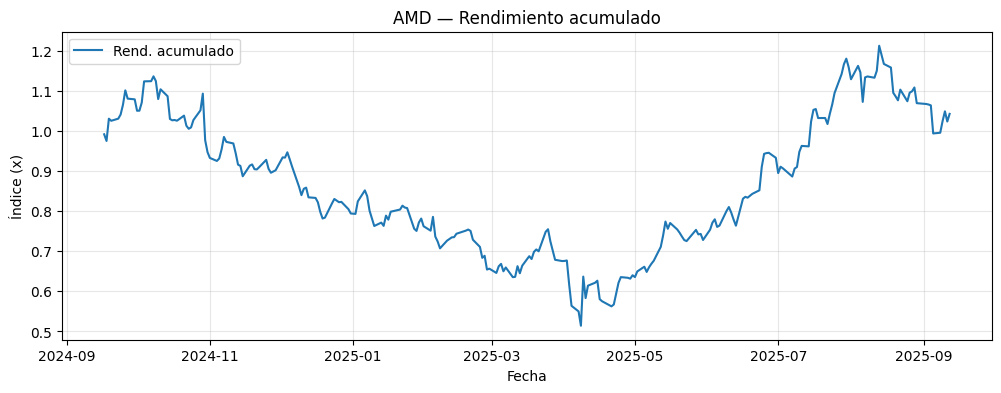

In [12]:
# 8) Rendimiento acumulado
plt.figure(figsize=(12,4))
plt.plot(data.index, data["ret_cum"], label="Rend. acumulado")
plt.title(f"{ticker} — Rendimiento acumulado")
plt.legend(loc="best")
plt.xlabel("Fecha"); plt.ylabel("Índice (x)")
plt.grid(True, alpha=0.3)
plt.show()